**1. Environment**

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
from scipy.interpolate import griddata # Other package for regridding
from scipy.stats import genextreme as gev

# Import some extra functions from utils folder
import sys
sys.path.insert(1, '/home/philinat') # to include the util directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Sep 24 2020, 16:55:52) 
[GCC 7.5.0]
Virtual memory usage - total: 187 GB / available: 171 GB / percent used: 8.4 %


**2. Geographical coordinates**

In [3]:
ds = xr.open_dataset('/bettik/menegozm/EURO4M_APGD/06-coord_lonlat.nc')
ds = ds.rename_vars({'Longitude':'LON','Latitude':'LAT'})


(<matplotlib.lines.Line2D at 0x7f24f4797370>,)

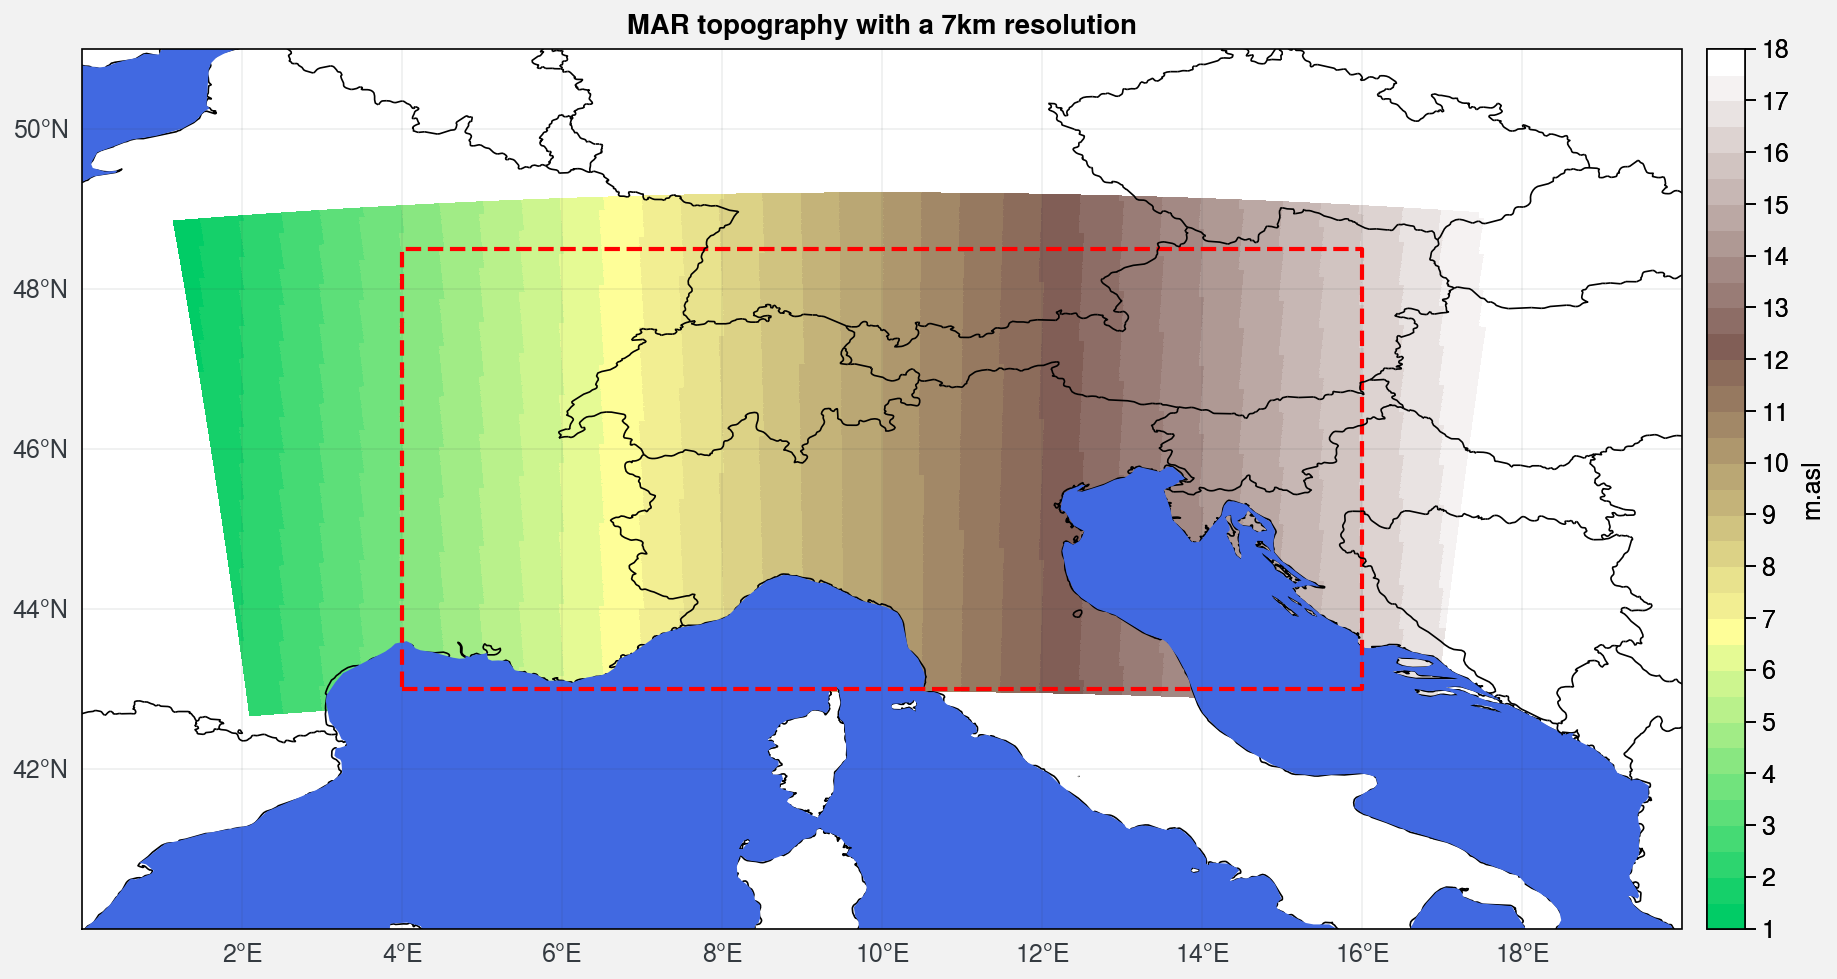

In [4]:


colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
f, ax = pplt.subplots(proj='cyl', axwidth=8)
m=ax.pcolormesh(ds.LON, ds.LAT, ds.LON, levels=34,cmap=colors_land)
f.colorbar(m,label= 'm.asl')
normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
ax.format(**normal_format,suptitle='MAR topography with a 7km resolution')
ax.format(ocean=True,oceancolor='royalblue',reso='med', latlim=[40.,51.],lonlim=[0.,20.])
ax.plot([4.,16.,16,4,4],[43.,43,48.5,48.5,43],'--r')

**3 Seasonal means**

In [7]:
# function for seasonal mean
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby("time.season").sum(dim="time")

In [9]:
first_year = 1971
last_year = 2008
les_season_mean = np.zeros(((last_year-first_year+1),4,138,243))
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    ds_pr = xr.open_dataset('/bettik/philinat/EURO4M_APGD/APGD_'+str(year)+'.nc')
    season_mean_year=season_mean(ds_pr.PRECIPITATION).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    les_season_mean[year-first_year] = season_mean_year
    
print(les_season_mean.shape)

1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 (38, 4, 138, 243)


In [11]:
np.save('/home/philinat/Stage-M2/saved_data_APGD/les_season_mean.npy', les_season_mean)
les_season_mean = np.load('/home/philinat/Stage-M2/saved_data_APGD/les_season_mean.npy')

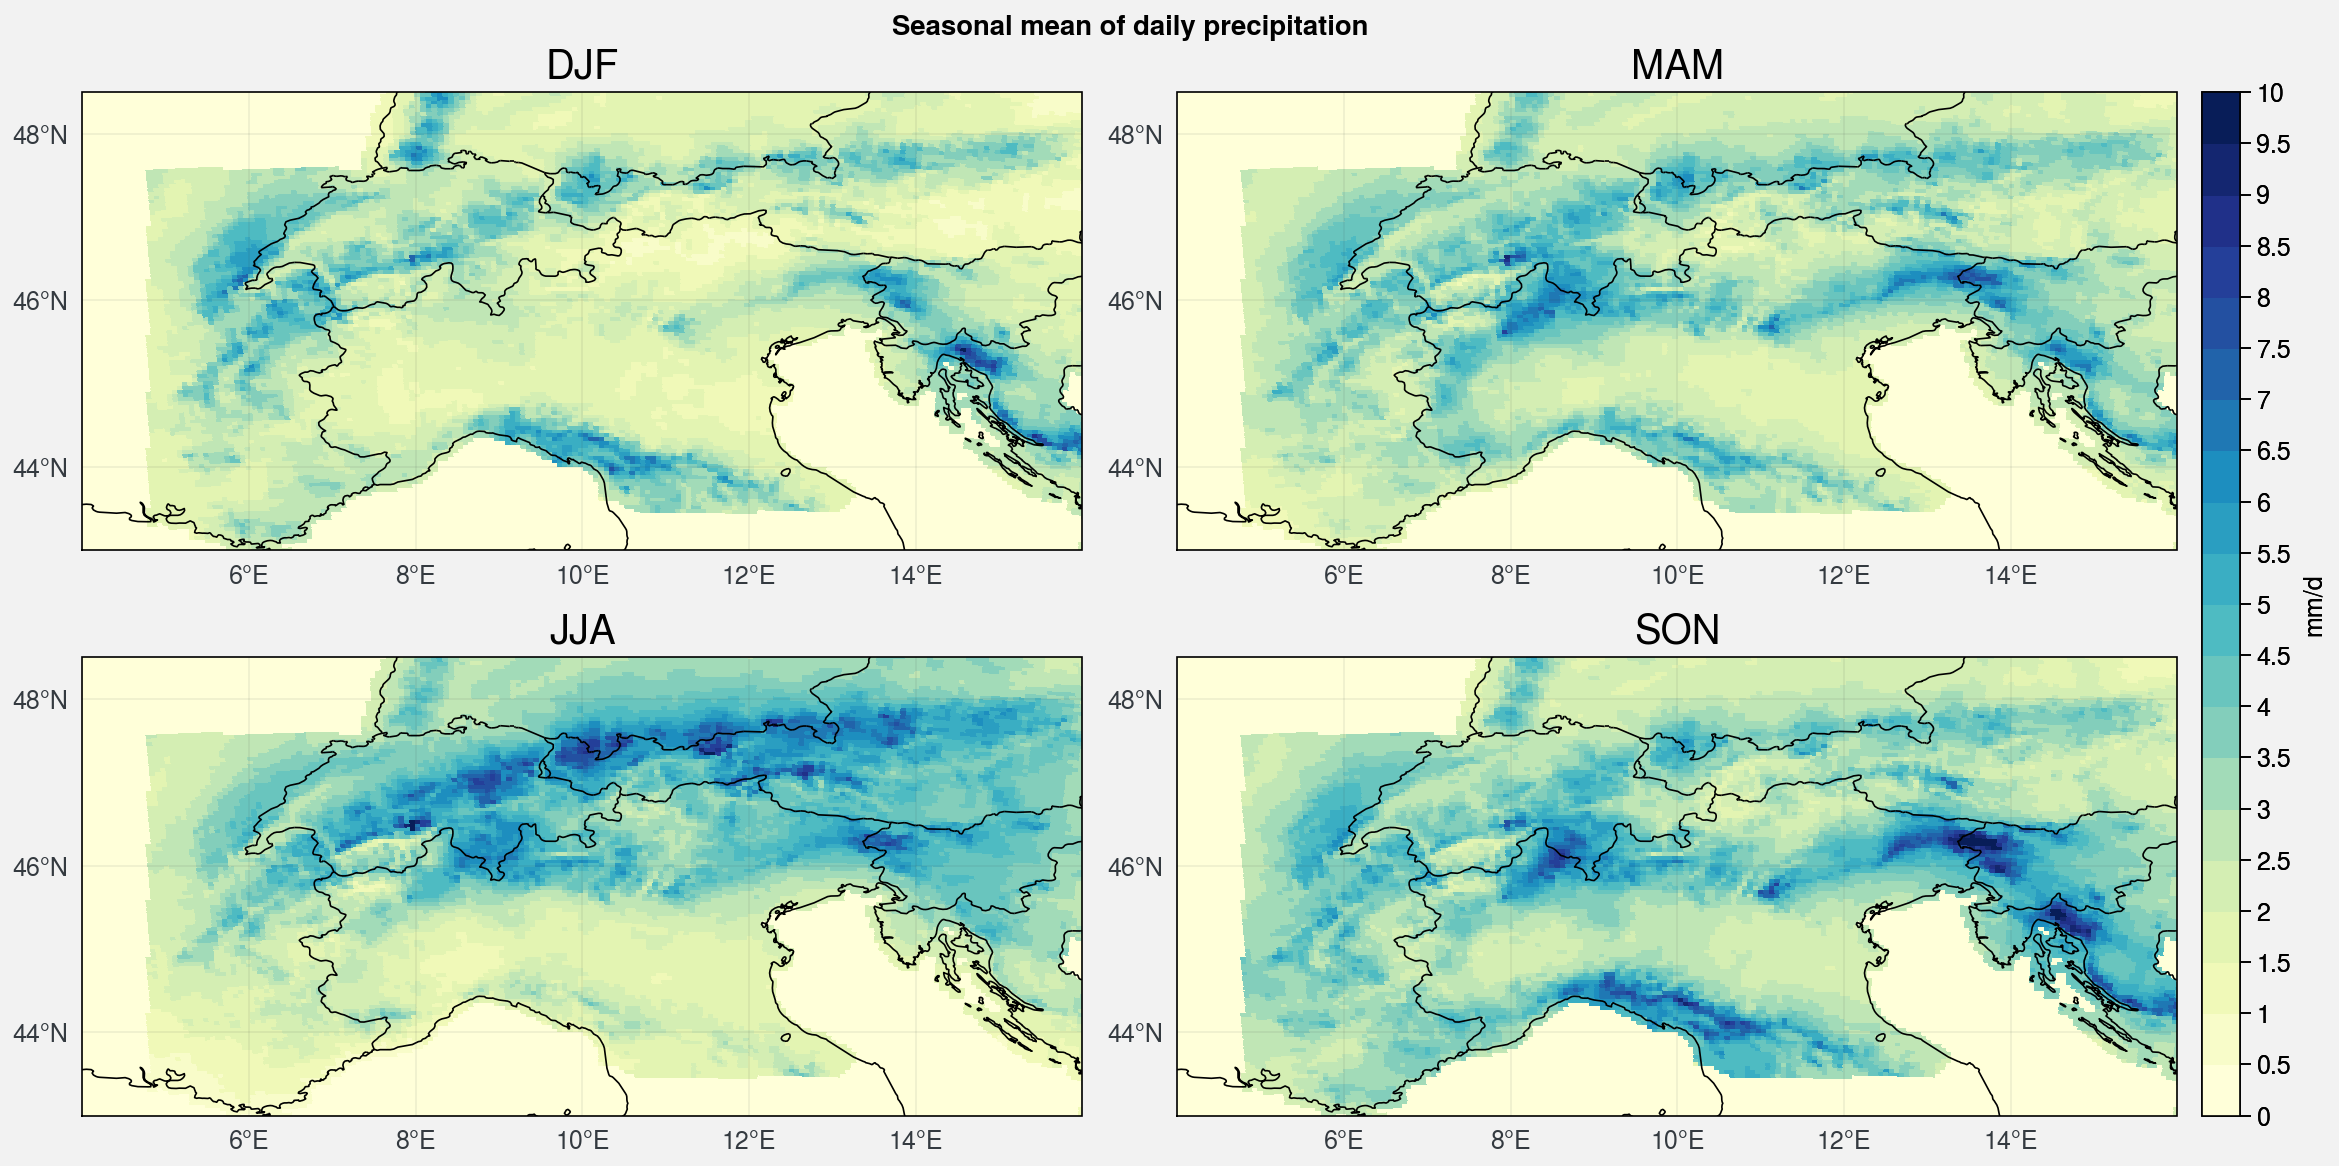

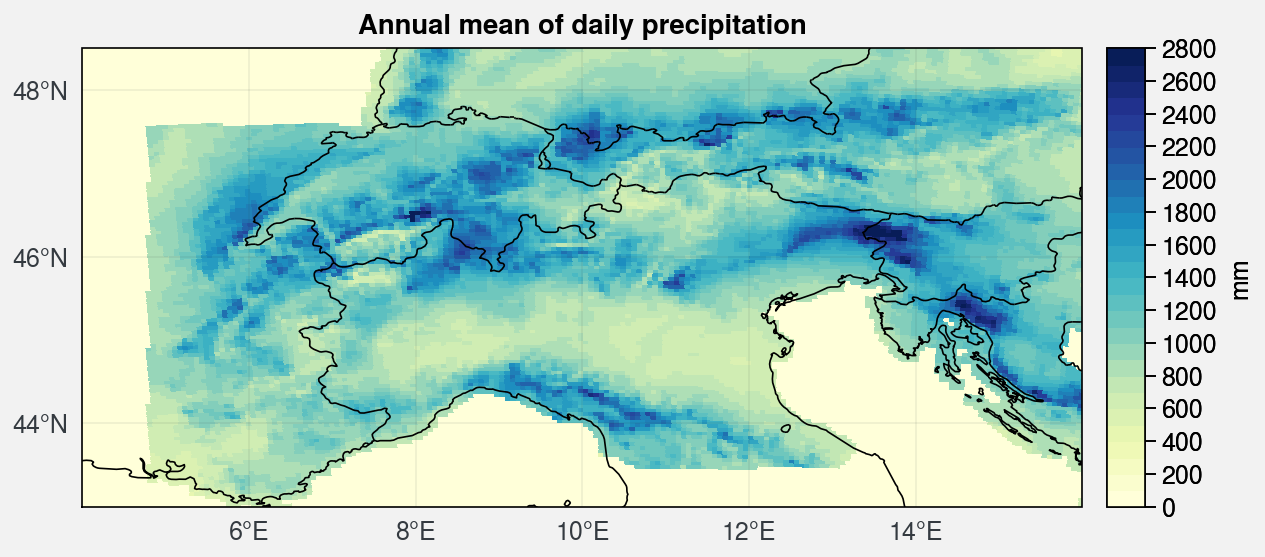

In [29]:
seasonal_mean = np.mean(les_season_mean,axis=0)
f, axs = pplt.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds.LON,ds.LAT,seasonal_mean[i,:,:],levels=np.linspace(0,10,21),cmap='YlGnBu')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= 'mm/d')

axs.format(**normal_format,suptitle="Seasonal mean of daily precipitation")



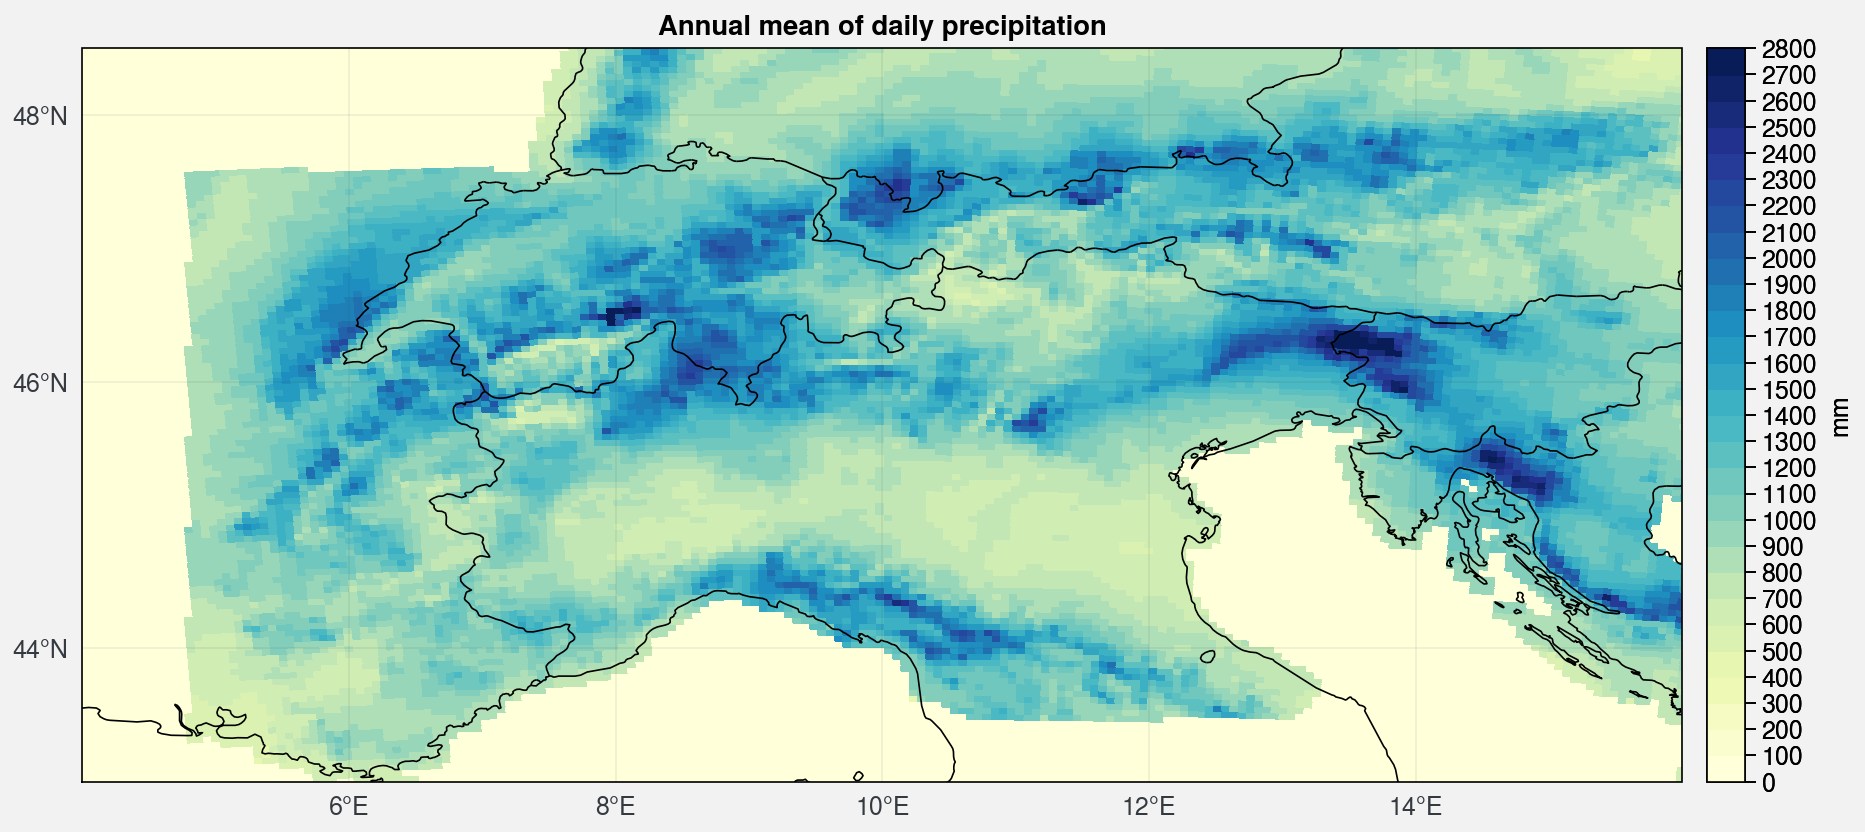

In [30]:
f, ax = pplt.subplots(proj='cyl',axwidth=8)
#m = ax.pcolormesh(ds.LON,ds.LAT,np.mean(seasonal_mean,axis=0),levels=np.linspace(0,10,21),cmap='YlGnBu')
m = ax.pcolormesh(ds.LON,ds.LAT,365*np.mean(seasonal_mean,axis=0),levels=np.linspace(0,2800,29),cmap='YlGnBu')
ax.format(**normal_format,suptitle="Annual mean of daily precipitation")
f.colorbar(m, label= 'mm')

**4 Extremes**

In [4]:
first_year = 1971
last_year = 2008
les_max_year = np.zeros(((last_year-first_year+1),138,243))
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    ds_pr = xr.open_dataset('/bettik/philinat/EURO4M_APGD/APGD_'+str(year)+'.nc')
    max_year=(ds_pr.PRECIPITATION).max(dim="time")
    les_max_year[year-first_year] = max_year
    
print(les_max_year.shape)

1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 (38, 138, 243)


In [14]:
np.save('/home/philinat/Stage-M2/saved_data_APGD/les_max_year.npy', les_max_year)
les_max_year = np.load('/home/philinat/Stage-M2/saved_data_APGD/les_max_year.npy')

-0.08913763193342593 49.31809574445502 14.327146677119547
0.25442838875742896 48.85471982644287 13.21709476748354
-0.13718011540546987 52.03157757677103 16.525102001586625


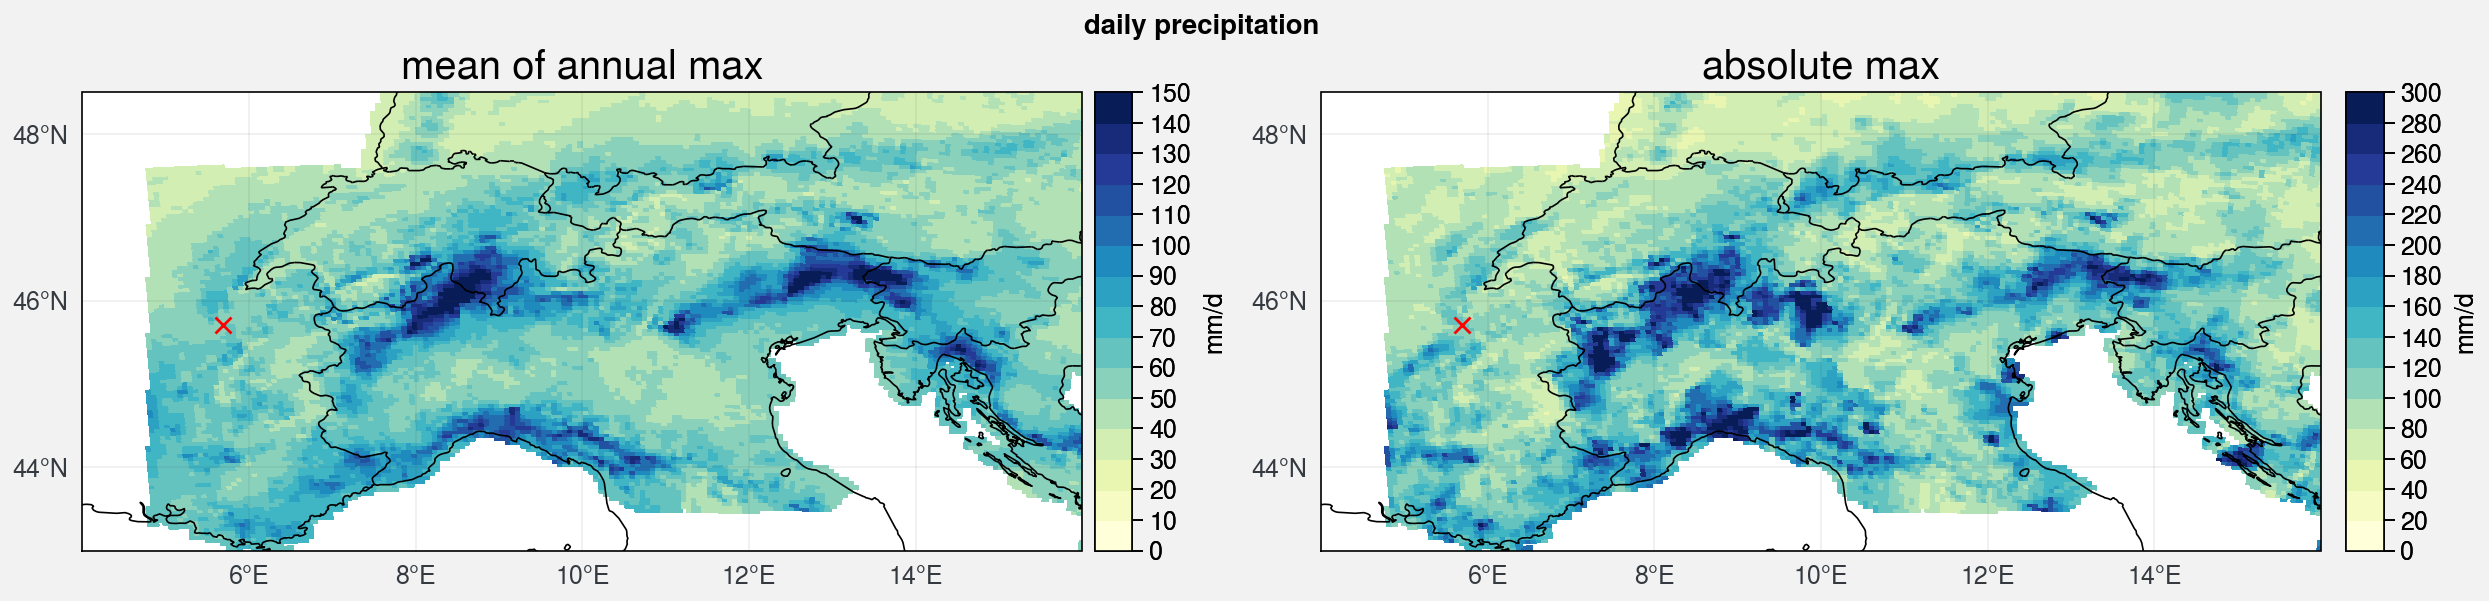

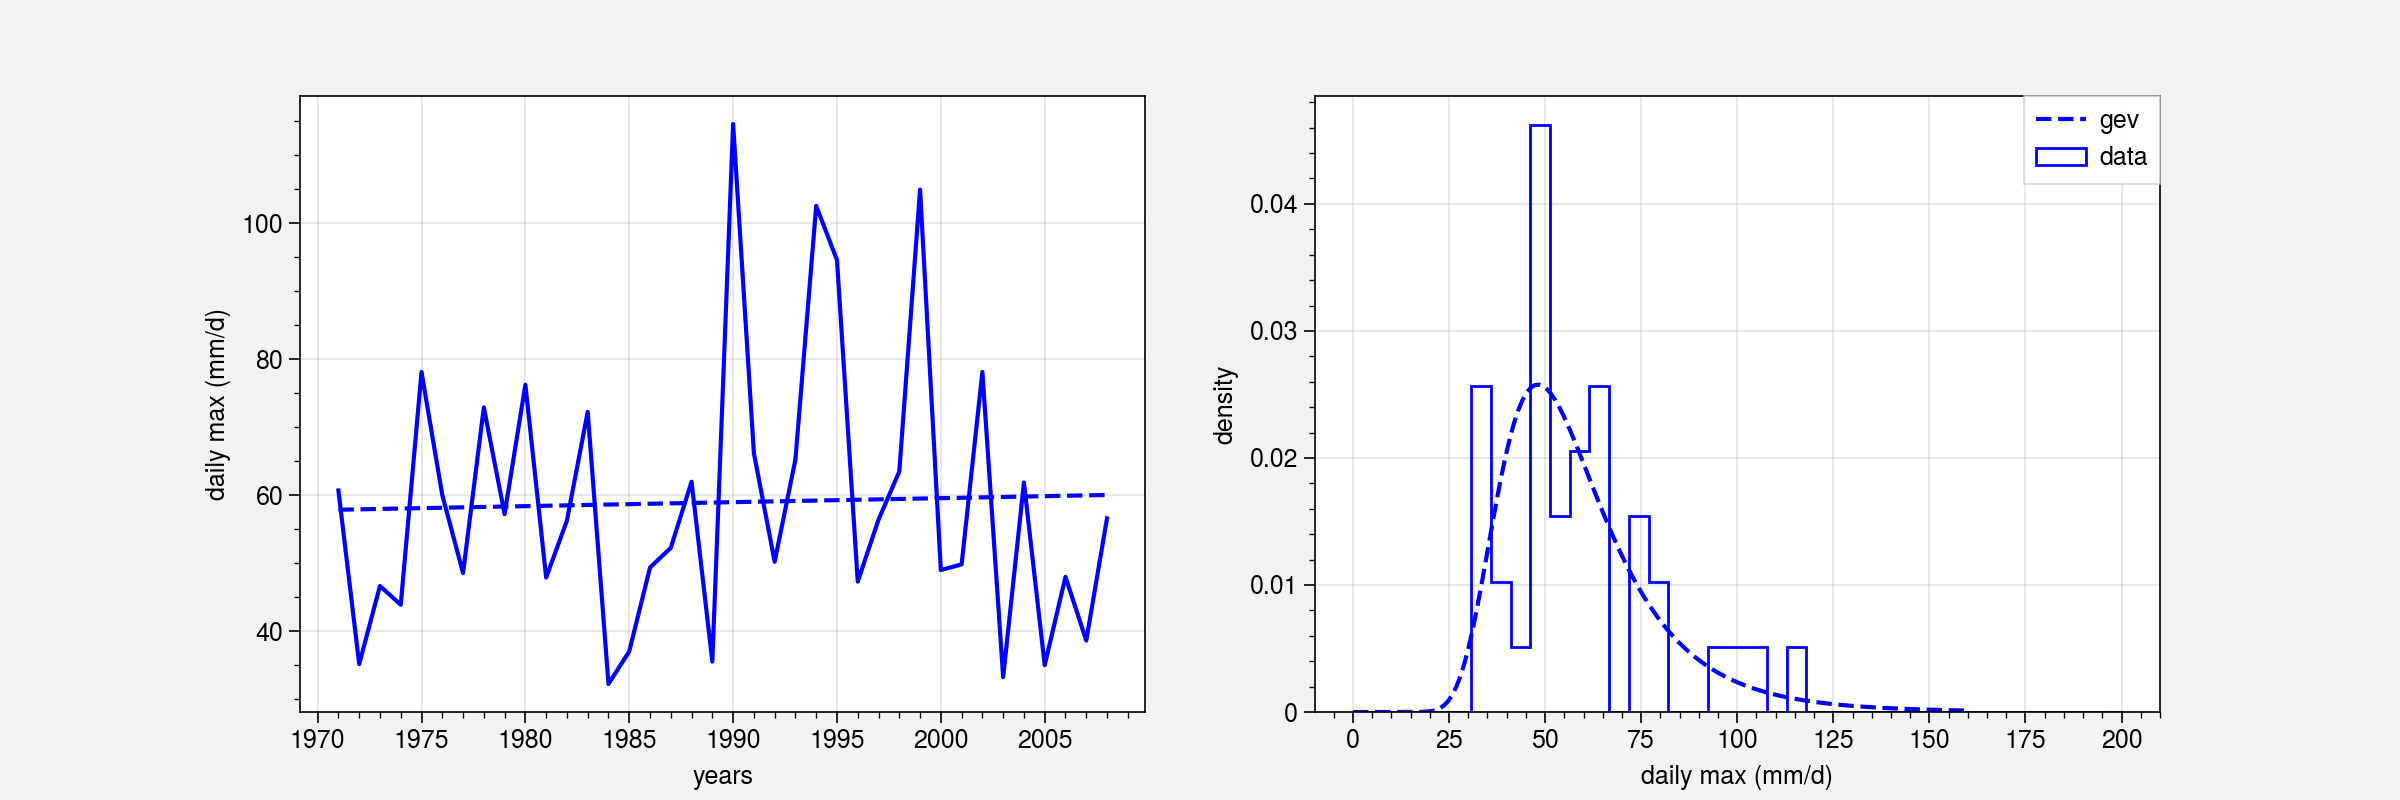

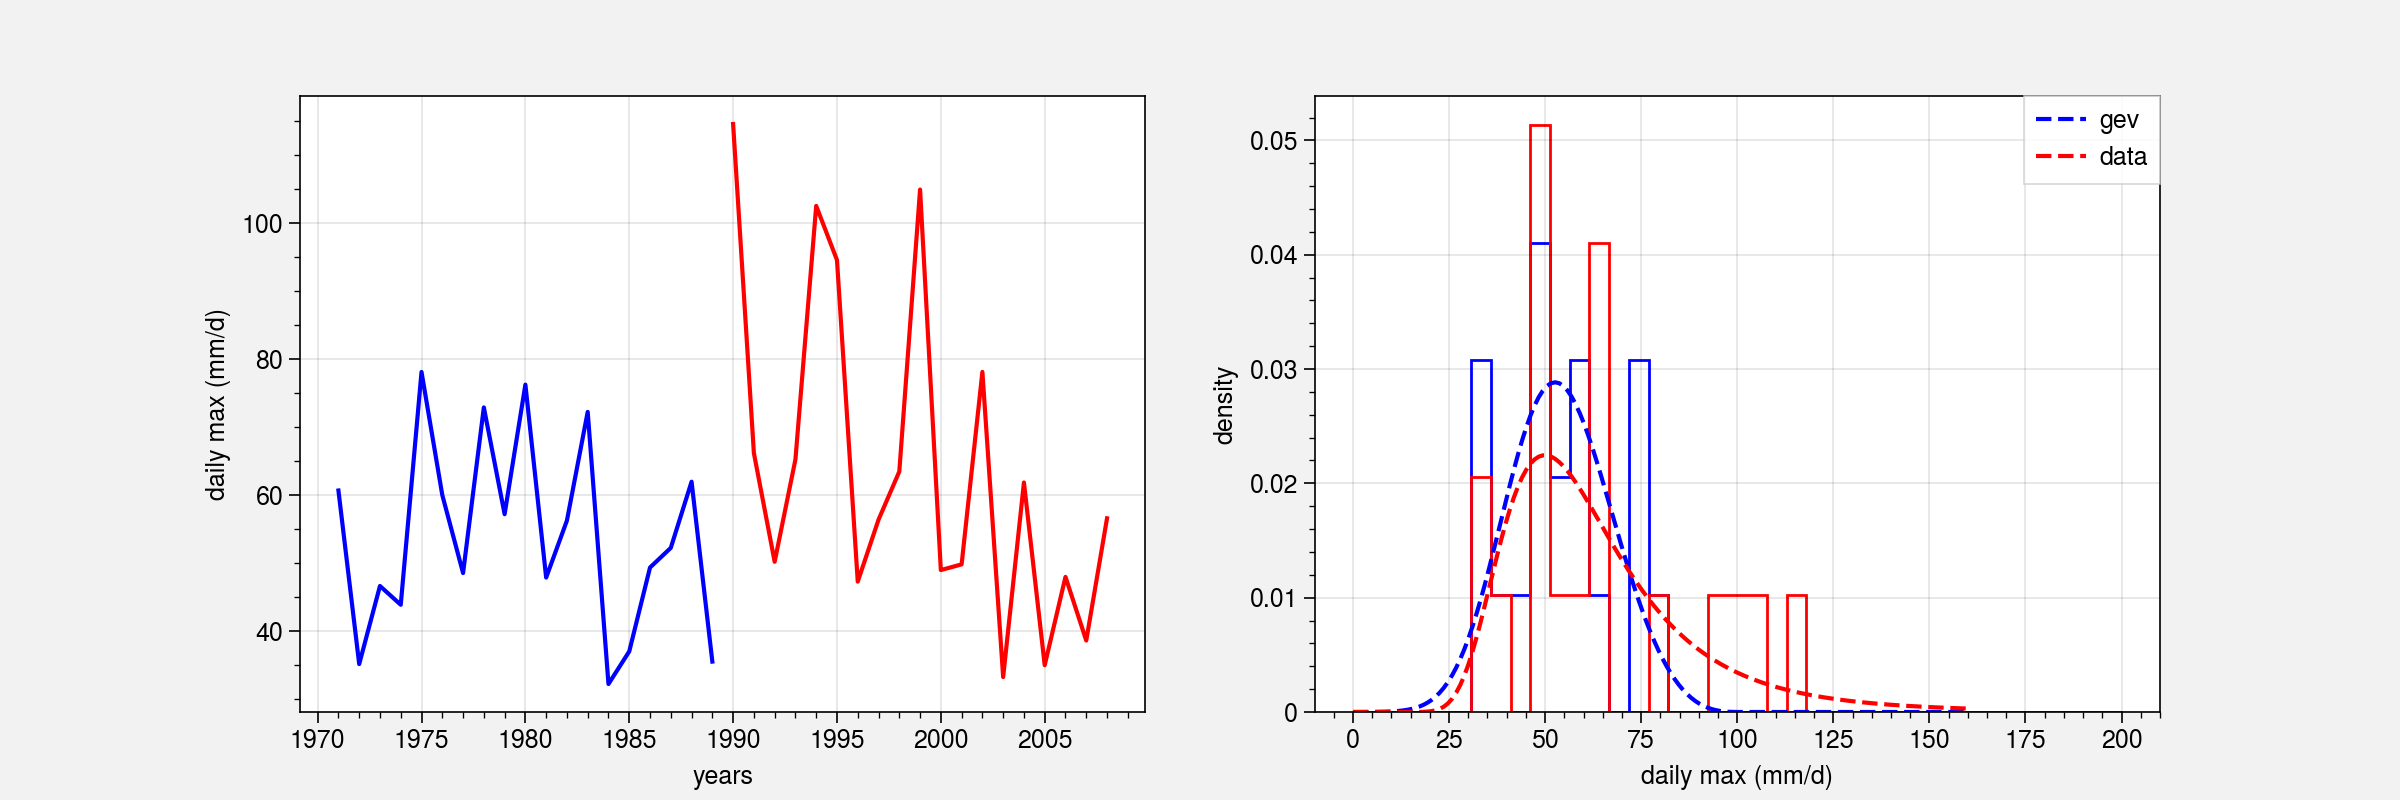

In [8]:
# Levels for the plot
levels=np.linspace(0,150,16)
# Producing the map, excluding the borders of the domain.
f, ax = pplt.subplots(proj='cyl', share=1, axwidth=5,ncols=2)

m0 = ax[0].pcolormesh(ds.LON,ds.LAT,np.mean(les_max_year,axis=0),levels=levels,cmap='YlGnBu')
m1 = ax[1].pcolormesh(ds.LON,ds.LAT,np.max(les_max_year,axis=0),levels=2*levels,cmap='YlGnBu')
ax[0].format(title='mean of annual max',titlesize='20px')
ax[1].format(title='absolute max',titlesize='20px')
f.colorbar(m0, label= 'mm/d',ax=ax[0])
f.colorbar(m1, label= 'mm/d')

ax.format(**normal_format,suptitle="daily precipitation")

i = 62 ; j = 62 # Grenoble
# i = 52 ; j = 52 # Grenoble
#i = 78 ; j = 63 # lac de garde
ax.plot(ds.LON[j,i], ds.LAT[j,i] ,'xr')

fig,axes = plt.subplots(ncols=2,figsize=(12,4))


first_year = 1971
last_year = 2008
t = np.arange(first_year,last_year+1,1)
maxs = les_max_year[:,j,i]
axes[0].plot(t,maxs,'-b')
m, b = np.polyfit(t,maxs, 1)
x= np.linspace(first_year,last_year,2)
axes[0].plot(x, m*x + b,'--b')
axes[0].set_xlabel('years')
axes[0].set_ylabel('daily max (mm/d)')

axes[1].hist(maxs,bins=np.linspace(0,200,40),density=True,histtype='step',linewidth=1,color='b')

from scipy.stats import genextreme as gev

shape, loc, scale = gev.fit(maxs)
print(shape, loc, scale)
xx = np.linspace(0,160,150)
yy = gev.pdf(xx, shape, loc, scale)

axes[1].plot(xx, yy, '--b')
axes[1].set_xlabel('daily max (mm/d)')
axes[1].set_ylabel('density')
axes[1].legend(['gev','data'])



fig,axes = plt.subplots(ncols=2,figsize=(12,4))

first_year = 1971
last_year = 2008
midle_year = 1990
t1 = np.arange(first_year,midle_year,1)
t2 = np.arange(midle_year,last_year+1,1)
maxs1 = les_max_year[:len(t1),j,i]
maxs2 = les_max_year[len(t1):,j,i]

axes[0].plot(t1,maxs1,'-b')
axes[0].plot(t2,maxs2,'-r')
# m, b = np.polyfit(t,maxs, 1)
# x= np.linspace(first_year,last_year,2)
# axes[0].plot(x, m*x + b,'--b')
axes[0].set_xlabel('years')
axes[0].set_ylabel('daily max (mm/d)')

axes[1].hist(maxs1,bins=np.linspace(0,200,40),density=True,histtype='step',linewidth=1,color='b')
axes[1].hist(maxs2,bins=np.linspace(0,200,40),density=True,histtype='step',linewidth=1,color='r')


xx = np.linspace(0,160,150)

shape, loc, scale = gev.fit(maxs1)
print(shape, loc, scale)
yy1 = gev.pdf(xx, shape, loc, scale)

shape, loc, scale = gev.fit(maxs2)
print(shape, loc, scale)
yy2 = gev.pdf(xx, shape, loc, scale)

axes[1].plot(xx, yy1, '--b')
axes[1].plot(xx, yy2, '--r')
axes[1].set_xlabel('daily max (mm/d)')
axes[1].set_ylabel('density')
axes[1].legend(['gev','data'])

In [5]:
first_year = 1971
last_year = 2008
les_season_max = np.zeros(((last_year-first_year+1),4,138,243))
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    ds_pr = xr.open_dataset('/bettik/philinat/EURO4M_APGD/APGD_'+str(year)+'.nc')
    season_max_year=(ds_pr.PRECIPITATION).groupby("time.season").max(dim="time").sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    les_season_max[year-first_year] = season_max_year
    
print(les_season_max.shape)

1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 (38, 4, 138, 243)


In [6]:
np.save('/home/philinat/Stage-M2/saved_data_APGD/les_season_max.npy', les_season_max)

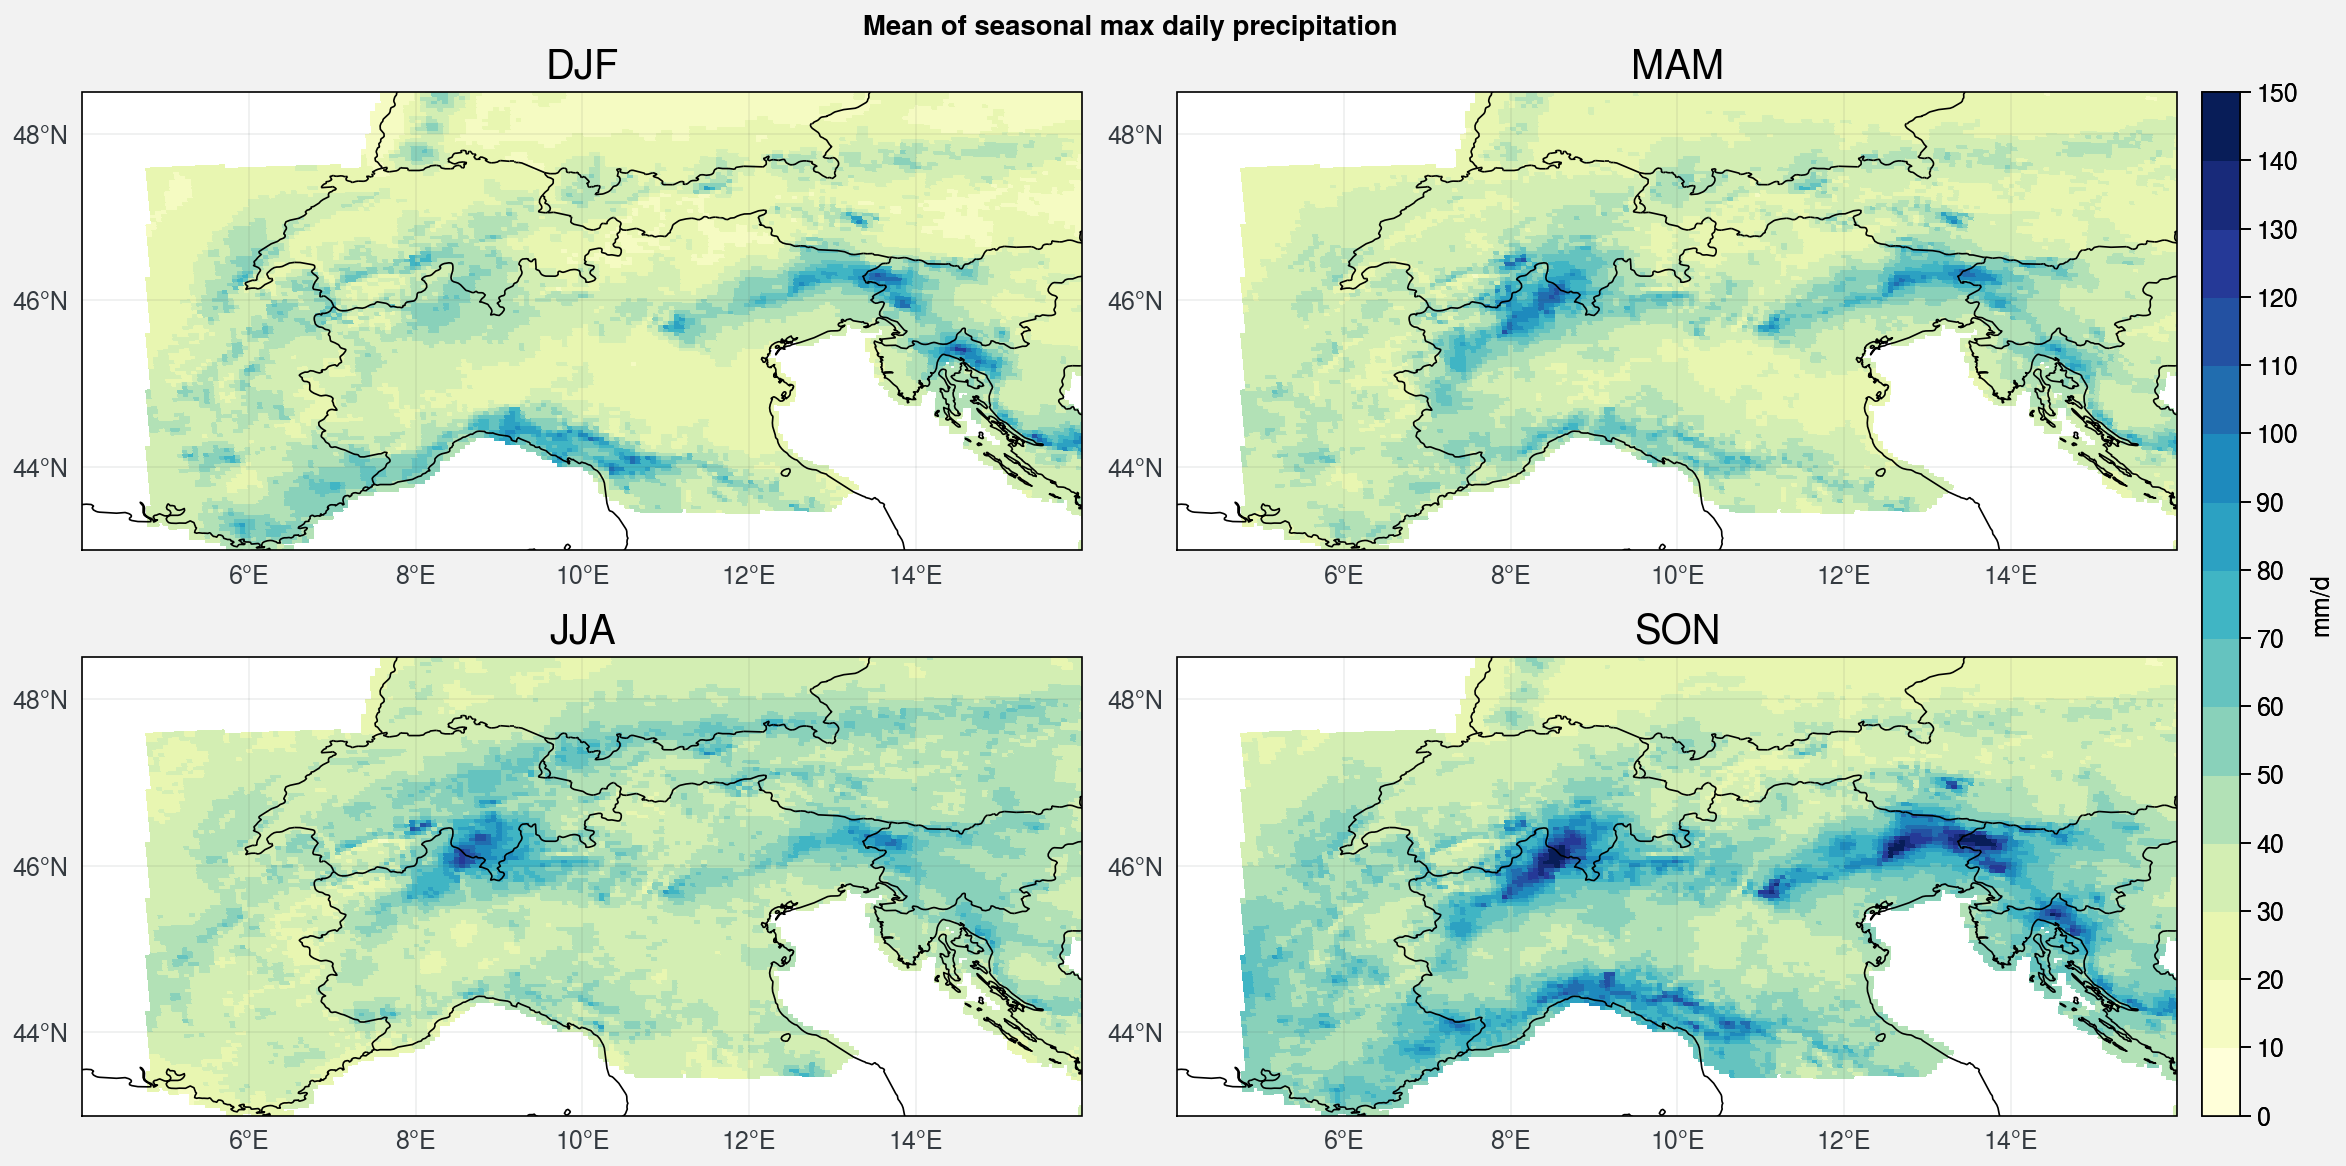

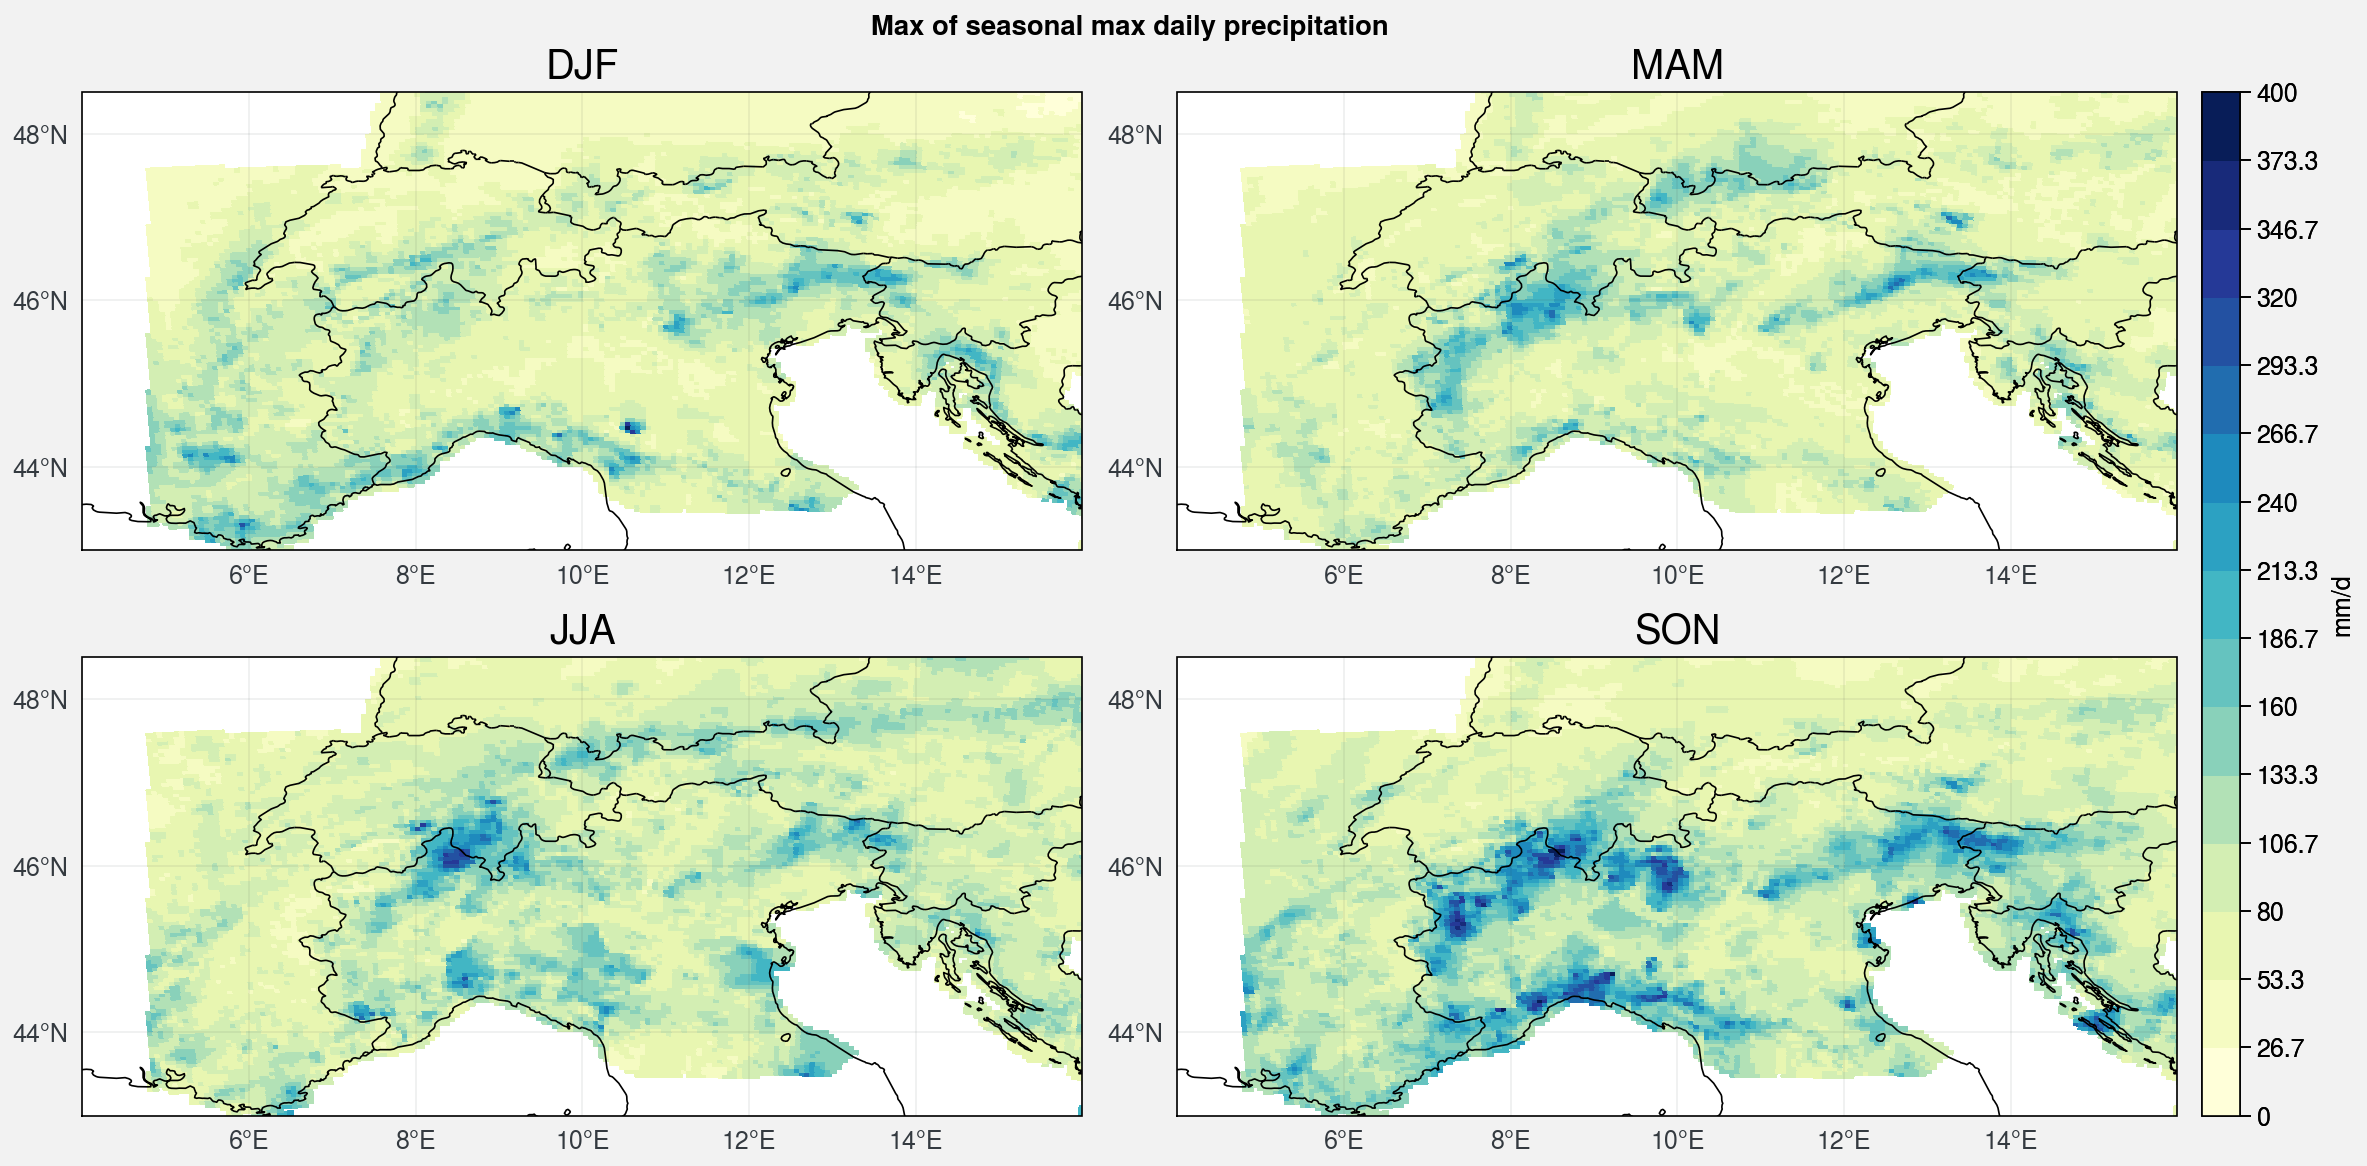

In [5]:
les_season_max = np.load('/home/philinat/Stage-M2/saved_data_APGD/les_season_max.npy')
f, axs = pplt.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds.LON,ds.LAT,np.mean(les_season_max[:,i,:,:],axis=0),levels=np.linspace(0,150,16),cmap='YlGnBu')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= 'mm/d')

axs.format(**normal_format,suptitle="Mean of seasonal max daily precipitation")

f, axs = pplt.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds.LON,ds.LAT,np.max(les_season_max[:,i,:,:],axis=0),levels=np.linspace(0,400,16),cmap='YlGnBu')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= 'mm/d')

axs.format(**normal_format,suptitle="Max of seasonal max daily precipitation")


In [ ]:
#season_gev_map = np.zeros((3,4,138,243))
for i in range(117,243):
    print(i,end=' ')
    for j in range(138):
        for season in range(4):
            if np.any(np.isnan(les_season_max[:,season,j,i])):
                season_gev_map[:,season,j,i] = np.nan*np.ones(3)
            else:
                season_gev_map[:,season,j,i] =  gev.fit(les_season_max[:,season,j,i])

117 

/home/philinat/miniconda3/envs/erca/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 

In [12]:
np.save('/home/philinat/Stage-M2/saved_data_APGD/season_gev_map.npy', season_gev_map)


In [13]:
season_gev_map = np.load('/home/philinat/Stage-M2/saved_data_APGD/season_gev_map.npy')

/home/philinat/miniconda3/envs/erca/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2162: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/philinat/miniconda3/envs/erca/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2163: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


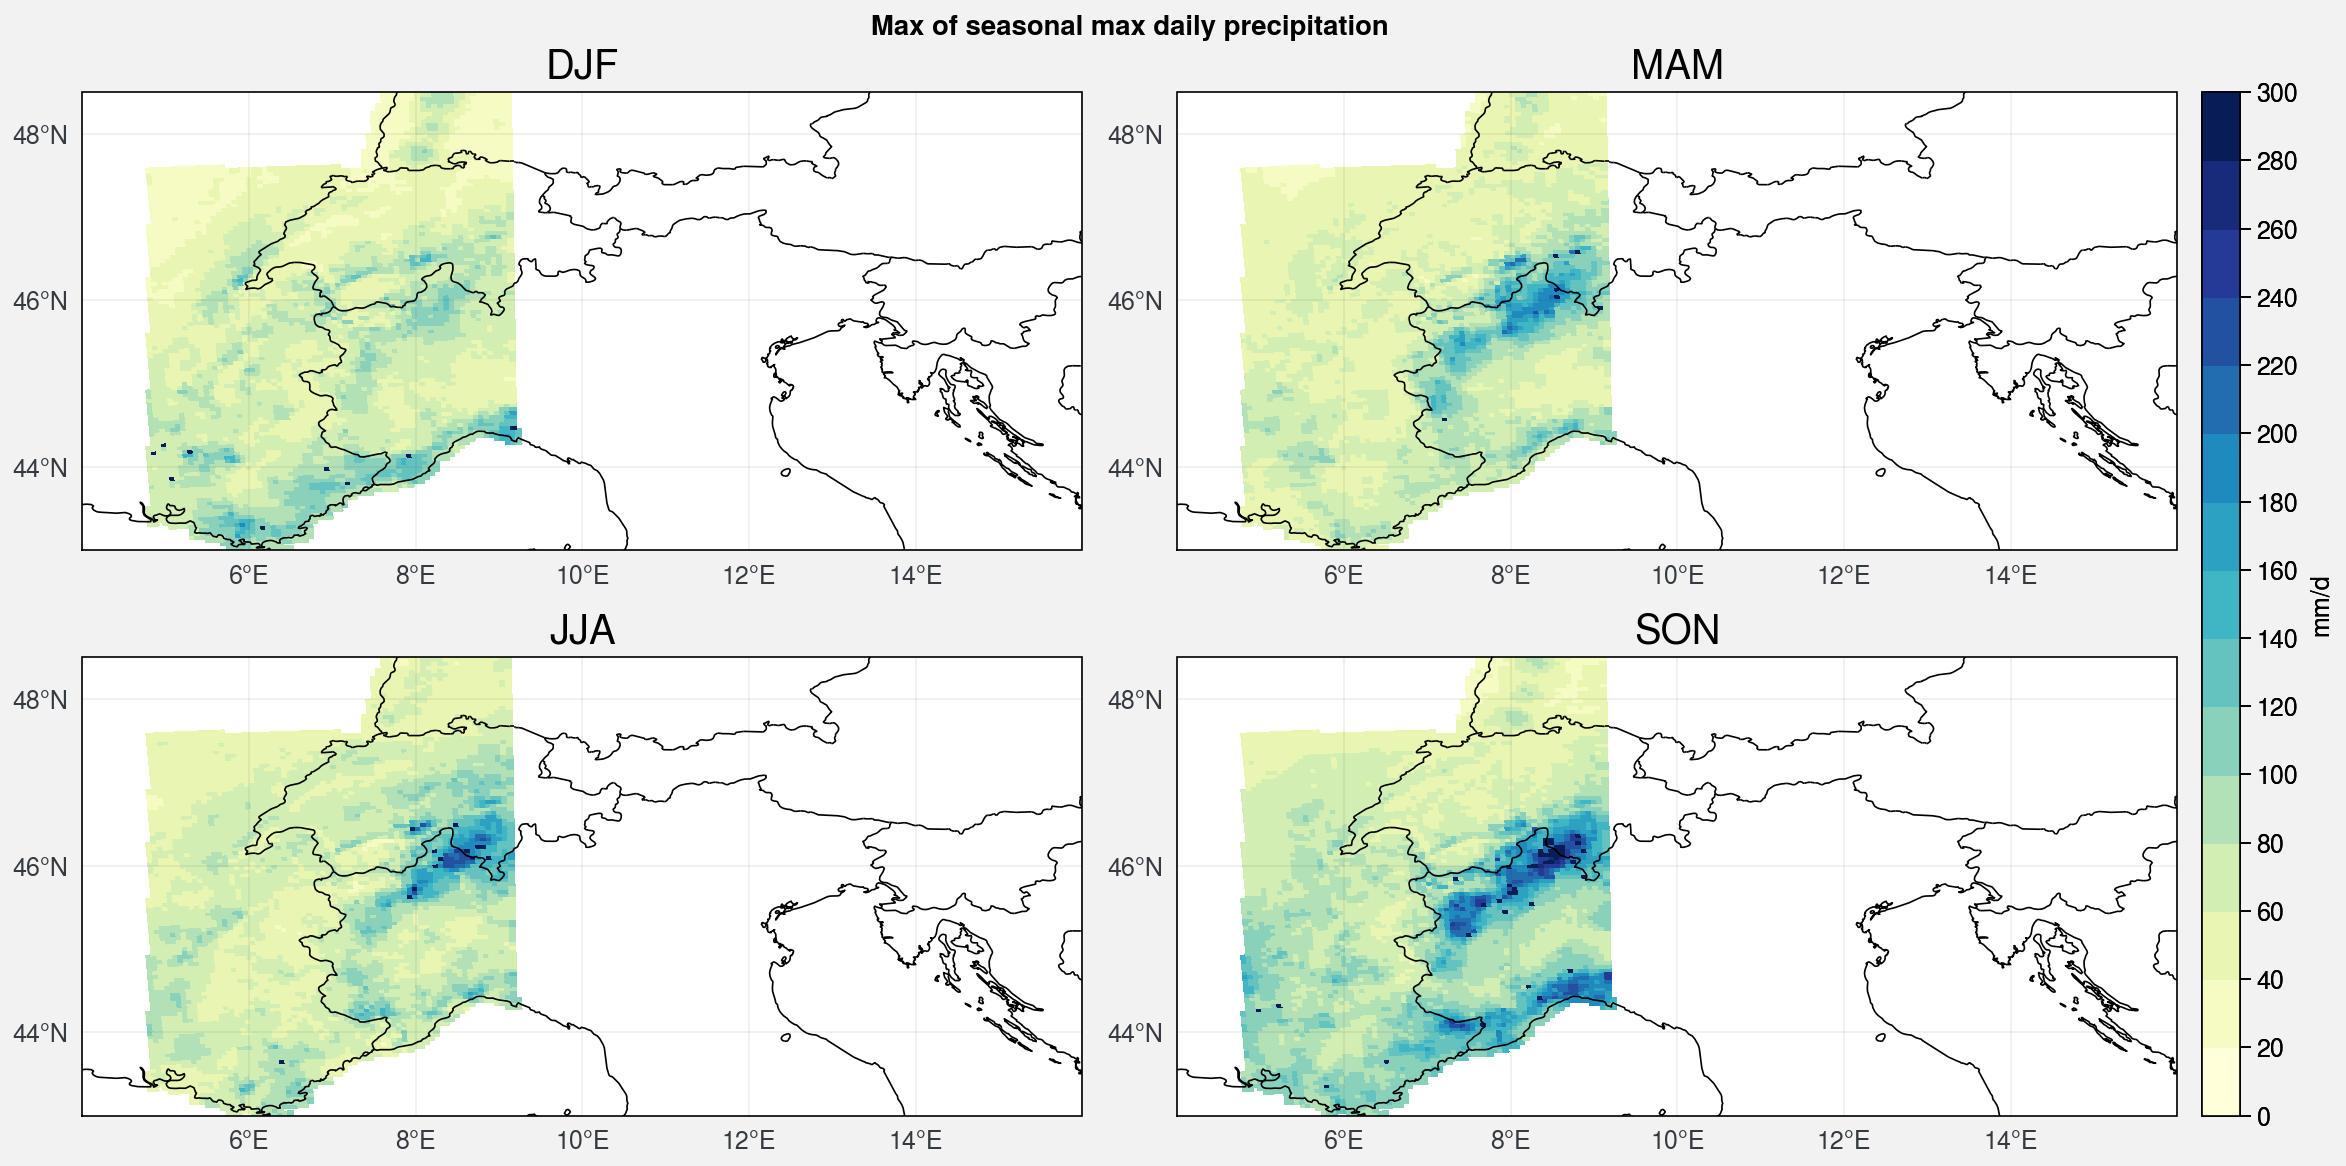

In [14]:


f, axs = pplt.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    data = gev.ppf(0.95, season_gev_map[0,i,:,:], loc=season_gev_map[1,i,:,:], scale=season_gev_map[2,i,:,:])
    m = ax.pcolormesh(ds.LON,ds.LAT,data,levels=np.linspace(0,300,16),cmap='YlGnBu')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= 'mm/d')
axs.format(**normal_format,suptitle="Max of seasonal max daily precipitation")